### Analysis software development v1 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
import lmfit as lm

# import data handling class
from DT5550 import *
from scipy.special import legendre

# %load_ext snakeviz

Open a datafile and read the data

In [217]:
#
# open the datfile / data directory
#
    
#io = DT5550(indir='C:/data/20220112_105851/')
#io = DT5550(file='C:/data/20220110_165917/data_20220110_165917_24.raw')

#
# loop over all the events
#
dt_max = 5

Etot = []
Etot_sel = []
nhit_tag1173 = np.zeros(8)
nhit_tag1330 = np.zeros(8)
nhit_untag1173 = np.zeros(8)
nhit_untag1330 = np.zeros(8)

ee = []
ee_1173 = []
ee_1330 = []
for i in range(8):
    ee.append([])
    ee_1173.append([])
    ee_1330.append([])


nmax = 9999
nf = 0
idet_old = 0

# untagged
io = DT5550(indir='C:/data/20220112_105851/')

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0:
        #
        # data: io.Q[0:ndet-1] -> energy
        #       io.ph[0:ndet-1] -> peak height
        #       io.t[0:ndet-1] -> time without timewalk correction
        #       io.tc[0:ndet-1] -> time with timewalk correction
        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
        #       io.R[0:ndet-1] -> peak/area ratio
        
        nh = io.valid.sum()
        
        # events with one or more hits
        if nh == 1:
            for idet in range(8):                
                rr = io.R[idet]
                rmean = io.config['detector_settings'][idet]['RMEAN']
                rsig = io.config['detector_settings'][idet]['RSIGMA']
                if io.valid[idet]:
                    ee[idet].append(io.Q[idet])
             
                if io.valid[idet] and io.Q[idet]>1100 and io.Q[idet]<1250: #and abs(rr-rmean)<2*rsig:
                    nhit_untag1173[idet] += 1
                if io.valid[idet] and io.Q[idet]>1250 and io.Q[idet]<1450: #and abs(rr-rmean)<2*rsig:
                    nhit_untag1330[idet] += 1

print('Processing done')

# tagged
io = DT5550(indir='C:/data/20220110_165917/')
nf = 0

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0:   
        nh = io.valid.sum()

        # events with two hits
        if nh == 2:
            id_sel = []
            for idet in range(8):
                if io.valid[idet]:
                    id_sel.append(idet)
                    
            id0 = id_sel[0]
            id1 = id_sel[1]
            #  the total measured energy
            Etot.append(io.Q.sum()) 
            
            delta_t = io.tc[id1] - io.tc[id0]
            if id0 == 0:
                if abs(delta_t) < dt_max:
                    Esum = io.Q[id0] + io.Q[id1]
                    Etot_sel.append(Esum)
                    if io.Q[id0]>1250 and io.Q[id0]<1450:
                        ee_1173[id1].append(io.Q[id1])
                        if io.Q[id1]>1100 and io.Q[id1]<1250:
                            nhit_tag1173[id1] += 1
                    if io.Q[id0]>1100 and io.Q[id0]<1250:
                        ee_1330[id1].append(io.Q[id1])
                        if io.Q[id1]>1250 and io.Q[id1]<1450:
                            nhit_tag1330[id1] += 1
                

print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
ee = np.array(ee,dtype=object)
ee_1173 = np.array(ee_1173,dtype=object)
ee_1330 = np.array(ee_1330,dtype=object)

#r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220112_105851\config_20220112_105851.json
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_0.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_1.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_2.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_3.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_4.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_5.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_6.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_7.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_8.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_9.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_10.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_11.r

A few basic plots: integrated charge and time

In [ ]:
#io.plot_all(type="charge",bins=50,logy=False, range=(1000,1500))

In [ ]:
#io.plot_all(type="time",range=(0,250),bins=100,logy=True)

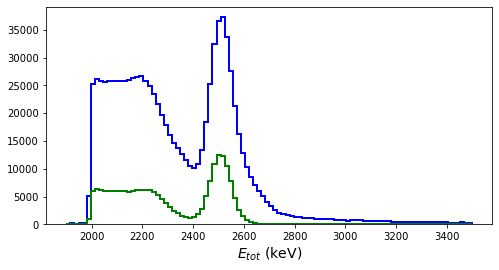

In [218]:
plt.figure(figsize=(8,4))

plot_range=(1900,3500)
plt.hist(Etot, bins=100, range=plot_range, histtype='step', color='blue', linewidth=2)
plt.hist(Etot_sel, bins=100, range=plot_range, histtype='step', color='green', linewidth=2)

plt.xlabel('$E_{tot}$ (keV)', fontsize=14)
plt.yscale('linear')

In [219]:
def legendre_polynomial(x,a,b,c):
    P0 = legendre(0)
    P2 = legendre(2)
    P4 = legendre(4)
    return a*(P0(x) + b*P2(x) + c*P4(x))

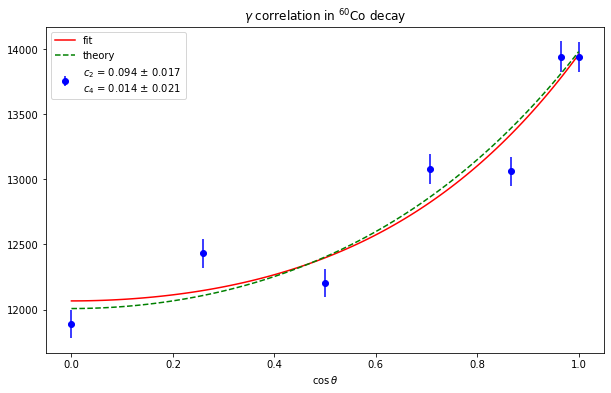

In [236]:

x = np.arange(1,8,1)
theta = (7-x)*(np.pi/12)+np.pi/2
cost = abs(np.cos(theta))

data = n_tag1173[1:8]
#data = n_tag1330[1:8]
#data = n_tag[1:8]
#data = nhit_tag1173[1:8]

#corr = (nhit_untag1173[1:8]+nhit_untag1330[1:8])
#corr = nhit_untag1330[1:8]
corr = np.ones(7)
y =  data / corr
yerr = np.sqrt(data)/ corr
#print(x,cost,yerr)

model = lm.model.Model(legendre_polynomial)
params = lm.Parameters()
params.add("a", value = 0.1)
params.add("b",value = 0.1)
params.add("c", value = 0.01)
fit = model.fit(y, x=cost, weights = [1/element for element in yerr], params = params)

a = fit.params["a"].value
b = fit.params["b"].value
c = fit.params["c"].value
a_err = fit.params["a"].stderr
b_err = fit.params["b"].stderr
c_err = fit.params["c"].stderr
xx = np.linspace(0.,1.,100)
#yy = a*(P0(xx) + b*P2(xx) + c*P4(xx))
#a = 0.03
#b = 0.1005
#c = 0.0094 
txt = '$c_2$ = {:4.3f} $\pm$ {:4.3f} \n$c_4$ = {:4.3f} $\pm$ {:4.3f}'.format(b,b_err,c,c_err)
plt.figure(figsize=(10,6))
h = plt.errorbar(cost, y, yerr=yerr, fmt = 'o', color='blue', label=txt)
plt.plot(xx, legendre_polynomial(xx, a, b, c),'-',color='red', label='fit')
plt.plot(xx, legendre_polynomial(xx, a, 0.1005, 0.0094), '--', color='green', label='theory' )
plt.xlabel('$\cos \\theta$')
plt.legend()
plt.title("$\gamma$ correlation in $^{60}$Co decay")

plt.show()

(150000.0, 250000.0)

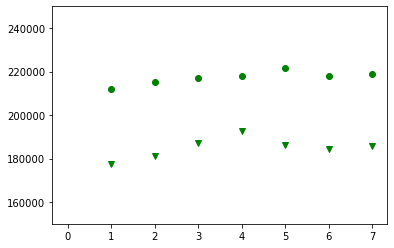

In [221]:
plt.plot(nhit_untag1330,'v', color='green')
plt.plot(nhit_untag1173,'o', color='green')

#plt.plot(nhit_tag,'o',color='blue')
plt.ylim([150000.,250000.])

In [223]:
from scipy.optimize import curve_fit

# Function to be fitted
def gauss_C(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1] * ( np.exp(-((x - p[0]) / p[2]) ** 2))

def gauss_fit(data, **kwargs):
    """
    Fit a Gaussian to a distribution
    """
    p0 = kwargs.pop('p0', (1, 1, 1))
    fit_range = kwargs.pop('range', (0, 3000))
    bins = kwargs.pop('bins', 100)

    data = data[data>fit_range[0]]
    data = data[data<fit_range[1]]

    # fit a Gaussian to the delta_t distribution
    y, xe = np.histogram(data, bins=bins, range=fit_range)
    x = .5 * (xe[:-1] + xe[1:])

    # Fit the data with the function
    fit_par, _ = curve_fit(gauss_C, x, y, p0=p0)

    return fit_par

A = 1059353.9443760517  ncount = 390966.0
A = 487402.1331476826  ncount = 177687.0
A = 494611.1556901747  ncount = 181400.0
A = 512188.1589087909  ncount = 187177.0
A = 541790.7448844542  ncount = 192844.0
A = 506368.76601523696  ncount = 186296.0
A = 502399.1477951137  ncount = 184624.0
A = 510980.54617231543  ncount = 185899.0


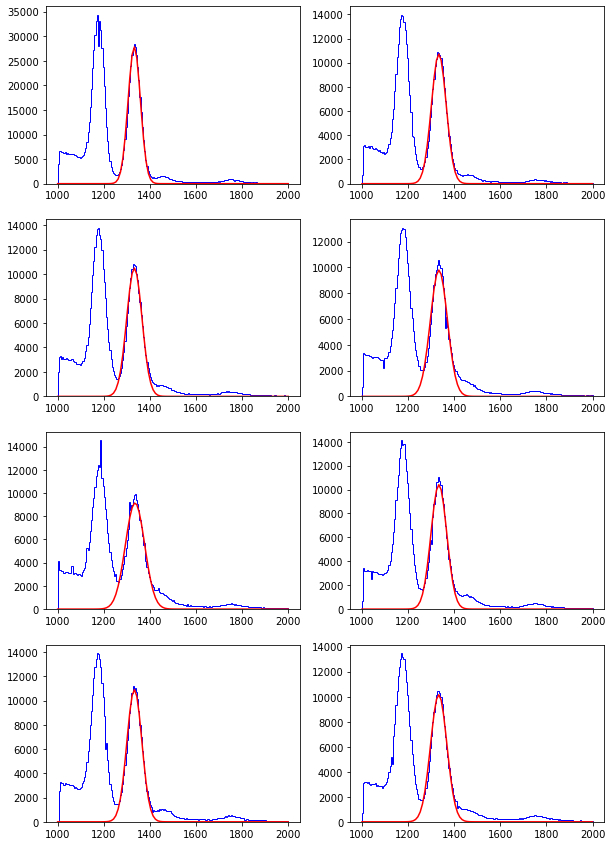

In [224]:
bwidth = 5
plot_range = (1000, 2000)
fit_range = (1250, 1500)

plt.figure(figsize=(10, 15))
n_untag = np.zeros(8)

for idet in range(N_DETECTOR):
    plt.subplot(4, 2, 1+idet)
    data = np.array(ee[idet])

    h = plt.hist(data, bins=int((plot_range[1]-plot_range[0])/ bwidth), range=plot_range, histtype='step', color='blue')

    fit = gauss_fit(data, range=fit_range, bins=int((fit_range[1]-fit_range[0])/bwidth), p0=(1330, 10000, 20))

    #data = data[data>2500]
    #data = data[data<2800]
    #print(data.sum(), len(data))
    
    xx = np.linspace(plot_range[0],plot_range[1],100)
    plt.plot(xx, gauss_C(xx, fit[0], fit[1], fit[2]),color='red')

    n_untag[idet] = fit[1]*fit[2]
    print('A =',fit[1]*fit[2],' ncount =',nhit_untag1330[idet])


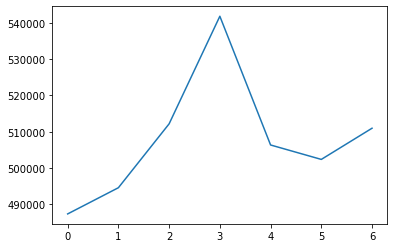

In [225]:
plt.plot(n_untag[1:8])
#plt.plot(nhit_untag1330[1:7])

IDET =  1
1  n_tag= 13938.33735616275 13966.364572348457
IDET =  2
2  n_tag= 13940.279554217726 13829.902416620125
IDET =  3
3  n_tag= 13060.448735920229 13229.908199915348
IDET =  4
4  n_tag= 13080.535020770518 12749.615156058097
IDET =  5
5  n_tag= 12203.507421796838 12087.32853676236
IDET =  6
6  n_tag= 12432.859942492714 12027.047392883278
IDET =  7
7  n_tag= 11890.843237852716 11767.834635363834


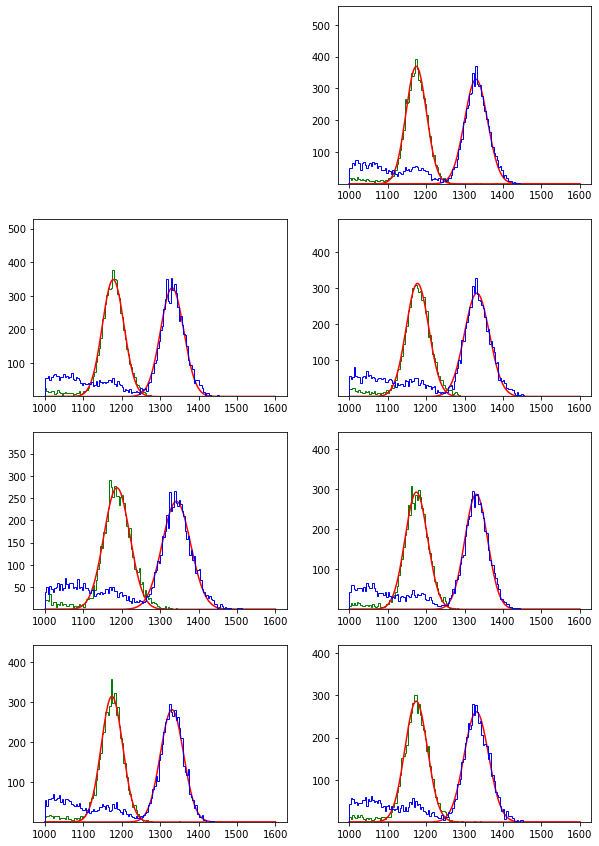

In [227]:
plot_range = (1000, 1600)
fit_range1173 = (1100, 1250)
fit_range1330 = (1250, 1500)

bins = 150
bin_width = (plot_range[1] - plot_range[0])/bins
xx = np.linspace(plot_range[0],plot_range[1],1000)


n_tag1173 = np.zeros(8)
n_tag1330 = np.zeros(8)

plt.figure(figsize=(10,15))
for idet in range(1,8):
    print('IDET = ',idet)
    plt.subplot(4, 2, 1+idet)

    # 1173keV
    data = np.array(ee_1173[idet])
    fit = gauss_fit(data, range=fit_range1173, bins=int((fit_range1173[1]-fit_range1173[0])/bin_width), p0=(1173, 1000, 20))
    h = plt.hist(data, bins=bins, range=plot_range, histtype='step', color='green')
    plt.plot(xx, gauss_C(xx, fit[0], fit[1], fit[2]),color='red')
    n_tag1173[idet] = fit[1]*fit[2]

    
    # 1332keV
    data = np.array(ee_1330[idet])
    #data = data[data>2400]
    fit = gauss_fit(data, range=fit_range1330, bins=int((fit_range1330[1]-fit_range1330[0])/bin_width), p0=(1330, 1000, 20))
    plt.plot(xx, gauss_C(xx, fit[0], fit[1], fit[2]),color='red')
    y,_,_ = plt.hist(data, bins=bins, range=plot_range, histtype='step', color='blue')

    n_tag1330[idet] = fit[1]*fit[2]
    print(idet,' n_tag=',n_tag1173[idet],n_tag1330[idet])
    plt.yscale('linear')
    plt.ylim([0.6,1.5*max(y)])

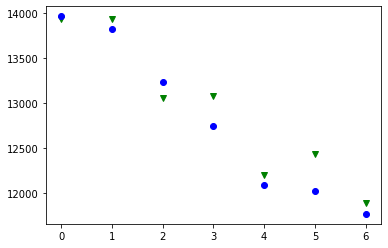

In [231]:
plt.plot(n_tag1173[1:8],'v', color='green')
plt.plot(n_tag1330[1:8],'o', color='blue')


In [237]:
np.sqrt(12400/12000)*40

40.661201818605086